# Modelo de Kermack McKendrick

In [3]:
include("Taylor.jl")
using ADT
using PyPlot

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-50

1.0e-50

In [3]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [4]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);
length(t)

  1.957780 seconds (43.87 M allocations: 726.010 MB, 2.74% gc time)


123

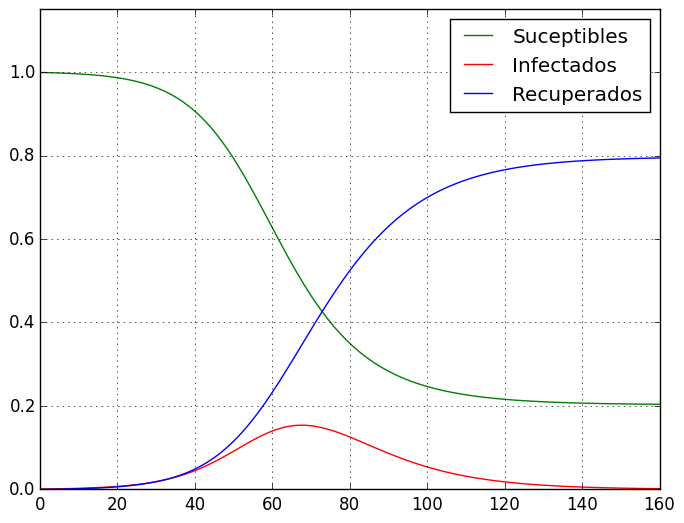

In [8]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

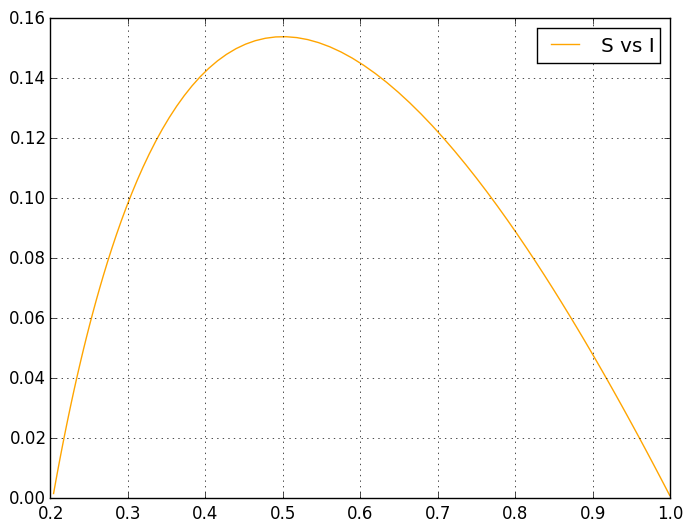

In [9]:
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()
show()

Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$
Como sigue, definimos nuestras funciones de coeficientes y el integrador.

In [10]:
function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I + p*R
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I-p*R

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1_re (generic function with 2 methods)

In [11]:
function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 10000
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

integrador_kermack_re (generic function with 1 method)

Establecemos condiciones iniciales e integramos.

In [12]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  7.409541 seconds (227.76 M allocations: 3.663 GB, 3.23% gc time)


639

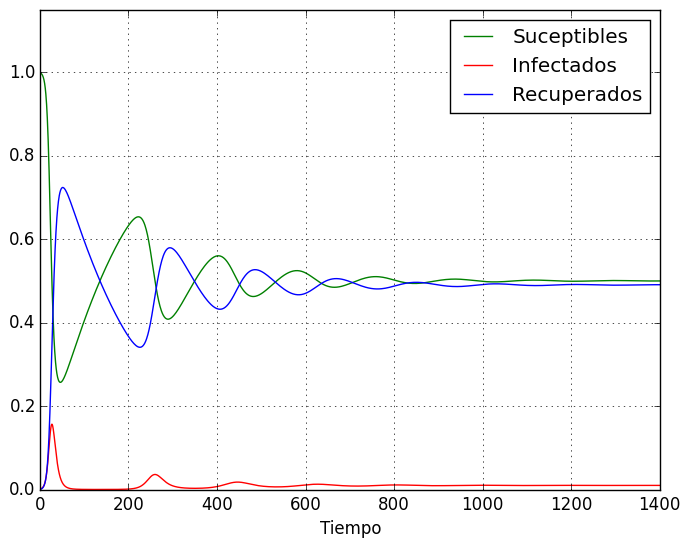

In [13]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
show()

Dibujamos ahora el diagrama fase.

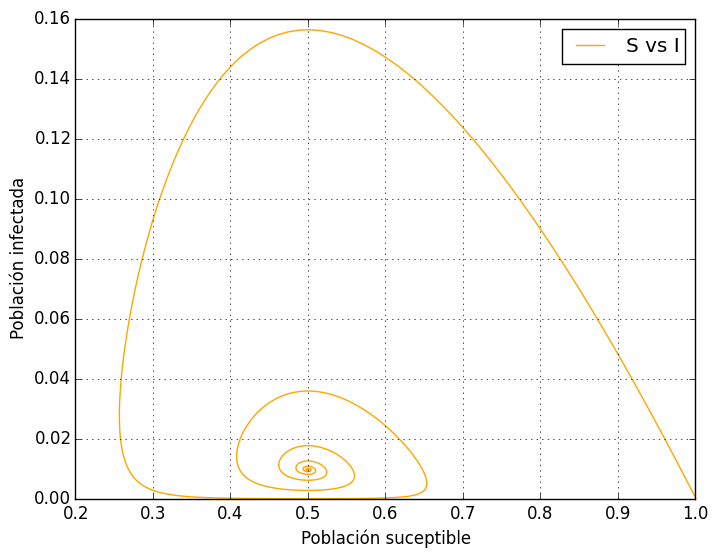

In [14]:
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()
show()

**Animación de la Solución**

Al inicial el programa debe ejecutar 2 veces la celda; la primera vez da error y la segunda muestra el video. El usar PyCall también interfiere con Pyplot asíque podría limpiarse el namespace para que no interfiriese con las celdas de abajo.

Para realizar la animación de un punto o curva que se mueve en el espacio se requieren 3 arrays: el tiempo t, los puntos de x como función de t y los puntos de y como función de t. Es decir que, si $t[i]=t_i$, entonces $x[i]=x(t=t_i)$ y lo mismo para y. Los tres deben ser de la misma longitud.

In [5]:
function html_video(filename)
    base64_video = base64(open(readbytes, filename))
    """<video controls src="data:video/x-m4v;base64,$base64_video">"""
end
#displays the video from the previously save file. This has the advantage of keeping the notebook size small
display("text/html", html_video("Animaciones/primerSvsI.mp4"))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAyidtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY5NCAzYjcwNjQ1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlyaWdodCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEQxliIQAL//+9q78yytHC5UuHVl7s1Hy6Ely/YgwfWgAAAMAAAMAAAMABVHrEQpsXdeGoAAAAwAX4AUVKvus9wBiAZMwTsbaN1vs6SZLa6gGEMlaKuxPaQRv4MuDq93agYM+iIwUOAsNd0G/24ZYfZry0c0GQYEvR7RznndStbNZF51kmwmGsDqteO5Pv9L5nmAqPkoce0hfo+Fu0TTWrAP2RMmd3vf1mDurq4O0xHlGlnsKTVAvCcGMjWMc813Ffgq5u5AWgGuCcNFH8/lghl7fdHfvhBspnvSj+eYoU4hKwoT5qtNm2qZuEHyaVcTs7YWcOhednf4hucLa7QZCJa2gSVaIjNDpV29c0dvTVs7GPjmnFFvzaLarlHz/KT7RQVSEebWiZzMEIba8HSkU1MdgWWbHRYzets7XWUKUS04YtLAyh+TQilPHdyQ/BPM3bxRdfVLbG0BgTjywNJkZSvbh/GzKciR64rXkU+1wHmKlQefoaBgCIJpPmBIwABuYWfqkkev/aeRsChX5Y/0/Rsi6Fk0i9aJRTuflezSg2kGPGyLWcD4gw88dakUG4PjIijoWJzAJPYHLvWIRY3qjjFi2UJDNnlEydGFzEnB2sQDgeI6tXnbZg87M1Ro3VaDRqa11FJWmlUSIUcDubBp6Z4ahBm67yQ004d0mBDtU+i0rTd0MA0zvVNP7O2ejaEEHJTiEP7tNvwaTC6fFVpCHRQJqn8s44Pa9E2NnXU4NXwExGeM6U/t3hf+WRb98ZAAAAwH7povA7z/yPSqyx/Exa5DIpojxDTUULgLMmkKXa9GfifVkQ2yvwGNwjO7lAW4DTYnqzwTtlgA7xoA0sATLDtIShZWILE7C5ZHFtWmHegUpaxK4HZqwlrLpfaFECPOL8SKPImKSngWInTd/c8wt+fuZCV+EsSOg8kv/9SWAAMHRX2urbo4QgEoAfgBHc3OY5QNRhmKAgw77SGJa7C4dmW9tWFemuGh+yfoPnuiQSRKRxIQJZeB9Op0DJ1Fv8kIuzZ5mGbQVUY6/n6Ry7xXGm8b3bSt1gNJpBL5TjQo97W53dYTujNK7OO+NxB3Vvc+icwkjv/H3Rolpz8IYah0AdoeQV6xVMAe3NeDB1bc/wwlezKx94v47S0q/FI2qTafiYtCJ1ZfxfJ+rVLjeaEH/mawCbAhOn2KfTc3dloH653IF7f4Q4Had5OZJcXgtkejUAAv9cL0TK2SapJfA8LqRPh+GRlWmRnfLqed0cxXL76rHF+NbgpNPU/5w/2SstE3GiMMtJGsAzNWUkhT/df/zAEhK55gpoqswJc75jzsloAi8yurtlvz9UYBhdQRpfkKnFGwDAAEZvPXKBClRAO2DsAI7rnvipSphnBgEtB9/oxFveS9Jzt5gr/fDdKfGTwID3gTtcQNGbTruy8p2WUQTJal27LYEFTR4iwZEI1X294JGpwR1Gnu8zjDBgLbA9Dtg891s9P2hMCGKZBtIqJJftg56NKXfD5RPNCWfrLt1SOeKkQlSItsBknoMtxOocavJcRMfJEUwAXtUhBzaQO59LdthhOYaDzovzuSkmxOef2U3KgfKAn5OPu0NaR+FdEx7IwGigQ+0CSWBYjKzXqrLKzf2PTROM5/ywpJoAy5v4agaof1+p0jeInbpobS56d7Fshly/tu55PY0UnQTNFlON9GU3ZHFN69GgOgAAAMC39L7fDfXVjWPijeLQEDcNV34j4DZPE60AAADAAADATjzV0u2wt6TQispWp26fCDwXJgar6AswQH23U0/dj4u6cvgp35dhCc4Zm3P+5V02WoAf7Or4apy1IeKh2G9k587omsS+oAANN5FnnlXA/eDrEH0ncRSiAdh5Eu5e4uAbd+kIICKOSZscs0FElZL/eIff7w+l4OpWQUYyC3l5VjjVryr1rL0xfRJlq+3m+y2TFm7hAQYuIOfLFBk+DdrwMFXo1WRiGvLcnOl1Lcu5+Ymf0/wvA3omlxBBJnYr532OLP52copaa2shhdqf4GPKGnaKNHyZNTR1AloBCCaqPGx/cEgNJdiaS2GhsmqDEWMMOQFw208XE8QHuEjqsqv7eSjSRMRpKQ23itjg1lA9PWlDxeTY8RkIvZVdb9ybKpo9sLzo8tqilYeNKxbToCEQTXZKgRPGJQrS3eLwAAAWakFKy78olObXYtARiamwxplcUPIual3jABhAFwBpAEJ8gEQQUHB12nMxby2WFQn9rAdpX5z5XNJUEVMIAv1yPpLPpMZj5aR/kBbepiNIm6rM+lhffM30vAQsNFv8JH0T9oregZs2FumiG5TyK0ZV122l3Au6iCg4zxmDbUIkF8OhgAFobwdwVf4mYZFNFbtp5BOXjzdVi3Ek5kQsoE2g8V5bIOJh2UFOiz6QQgb8rAr13zXGERU7889EYjsf/09/MamHlS9y8rIbR2GJoHKABf6n8ric9uu2vkmBYJvqUi21+KQlu+PrsM/melQ3BP09jvat4MupPZF5MjTO90/cgsq38Ox0lcgfZYBFipt//N79aDMMIqaH+wbuPmNKyVSDbDbrU7jqb53u5Ba9eXNd3omSj6mg+Gu5VZaUiLXknwjOEPdSAIWKoQF1dxSJzYag09Jw/DFUOkch6GAALFl+X+nu99mZoI9rI6m1HR/lxRy7Cjx0KvAAAADAABUi/hw+zTzBv0CWlDjy//J+OT3yCEntsFz4CPXqB801zZyuj6VUxWkKnxRTm8m1qKghzV1HFy2n2vliGn6StuRXDkNq5NpyUe4OLSE4KroQ0yp3PUqF/fnUiAjuMpJMwJYSheeUjHYK7qjjn/DgWU1bpHG9t74hSQGgzdCrykw59CbnLVNN7po8cpBRhu+2qHIbxYZqAABZ/hLl5foYmRgnIy2JChrxmS1YBzfqQ6nHY3f4YtOsdt/XCl0L2WOxXWXKRlXdyki2nXvFl1koMMMrqaeXWBH30jNQGc

 in depwarn at deprecated.jl:73
 in base64 at deprecated.jl:30
 in html_video at In[5]:2
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at C:\Users\ARTURO\.julia\v0.4\IJulia\src\execute_request.jl:183
 in eventloop at C:\Users\ARTURO\.julia\v0.4\IJulia\src\IJulia.jl:143
 in anonymous at task.jl:447
while loading In[5], in expression starting on line 6


# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [ ]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

In [ ]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

In [ ]:
N = 1.
I0 = N/100
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 150.
beta = 0.2
gamma = 0.07
mu = 0.002
f = 0.055

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
grid()
xlabel("Tiempo")
legend()
show()

In [ ]:
p = 5

for j in 1:p
    
    N = 1.
    I0 = N/100+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.28
    gamma = 0.09
    mu = 0.001
    f = 0.085


    @time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    title("S, I, R vs tiempo")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(i,r,color="turquoise")
    grid()
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
end

In [7]:
display("text/html", html_video("Animaciones/_IvsS.mp4"))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAo4ltZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0OCByMjY5NCAzYjcwNjQ1IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlyaWdodCAyMDAzLTIwMTYgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAEOtliIQAM//+9uy+BTX9n9CXESzF2kpwPiqkgIB3NMAAAAMAAAMAAAMAA0AdraId2gkE0AAAAwAL8AKKl/3We5nzAJffvNG2j0cDjHm63xYBOR7oMKk0zAiN/MHdBfynKeldyS9TwpI70RoxrVMTZPGLFVKBCDSqUTG8Pn+G7SVUIZ99s/P9r+UBfAuLiPMC5WPyBDB4Vn+SUgofb6qt5w1qKA9MQAPH6yISvGU0S7M9NIH5pgQHlI9d3+ZCzugUZGH6FDcF/dwS8dwaNqO70B2O/qgymRYtaBEUtyMO5m2sZz0eLNQXO8DqrFAlBYea46RL8aMPQixpvH0GxWyuVNv3thHV3UXeXjE++1MPu44Vk6efLPBujPnyv6m+FeCTC0koPgqeVo63ZeBy8kb2gu7jf8cxPBi6Zy+qJqMu0s2VPcxRt1Q28zQfxnXDn2AyTWfn0mR7a6QJo2UKh09tzaIloEkQnC/y0dJDAKkz+KhZk93DSMng+qgWXeREFAhq5vmmNUWC0eptdVxdA32rq5von+k42vuB3YdPFc7QckTDFZIi5vMvtib9qxAyIpjJWkj0WSG6ClbSTuiCpvlnlkvZjdlSYM/pKZTZ+Jk+v9SDxVHKERof+IIOPbT33zDfaEzeNfH+jYENBuLIpH6KGQCDjq6EGJ18JrR4S054xlzNj2lo0yNP+WFvredGIjlOZRL+1u8QEpeWXuMwafb5txict1dLy+uq4IUyyjBRPU6OhRSEqnyklN12Msm438Vnf4xOr6YIGenqjLPz/eML7ad2PxWuxZzYKCmdJAsnECww6PCTSIpnPMflz8oIav5WNEnCeCsb6X4F9vBmdt8kOsYDu0P7OdZG0TIK3EEtQbtDeOkoEvmTHkpXNLRJmy1dD70qh9HTSoZCCgJhLJTlfytiMsNNG9JxVq9SvL2pOuhp93++UiG8qglID1knrftDzyCmiGg13OKDOAAAAwAAZR9DX5thmWPNJyp7h3KqCyU13RiwcSoeUCTa2AAI7DJSABOo34CVGT8MtjACEltWEKHGdFoZe5LcUvoO31kq7APEAlVTAWwIj0tRB7Lalme5sBVcfShAvurwhMyHL74Dc7gQwxAAfxe7AeeZKDIBDvuGnyD+ZX05b1snE5J/7w3+W5X44ZXo/dADgbQ7PD8yNHT7akB9U8PsDuFYOr6iMTQNYa97gwJOkb9sFpUEsmTYyB9Xw2cGzB+LgK43TVr/2xJRgp0CRSrHoP89SNN48PhMaO5gHCIWDKSXfbZIAvI4mx+2OGjnpgPMjIEu6FTIHgqde9/0qMWVnRe1DqnbxN8dXDhbUDh19Qs8jq+CISNH9XCUYF7OWIuCEpo0Wjv5TiS7AoOZcXgAr/yaPfXqXoJLcEXPNiNpSWqt0KO50Uf4BqDjadpzSj4APtBeIn7AdwAABQ7S+XG2iLbMwQ9bV9khZgW8HDNT1oW+3h4lgGCBFAChXK34DGN5/NfNCUV/dlPGBUoLSkyLWMHlQrOR4bpUwciZYB2hO2YqB5/UEkUhcvnBwtPjroyMYlzLd49vRQe0AAFvmR5utZD457+TDCqZgs3LDNNvjYTJD8g/YBYadyPAjR2fuZTERP0TajR9gxTKiBlUpJBadBVx6VENZQuGIe5CyczAgvNd9NOIJhnjIvJRubAQBCsgTSQFREjiJ7w+T9GdujLTX24KuF0V27hc5P9Tv+iLc0s1PBCBKaIaLypeUPKRbnXgKOS69sEDAHZo6xdkADiI+phE1eLE5rNGBPz4H/nqYLOEvR6zYDrVUNhkA32rBo14gfBi5AcW6GY+IFl8eyk5rGUWPaf0mc+ahMWA0dMW/GTlVnskmilnDIWXicJcAAAZyYSz4H0uS3g5Hl9su3VWBtu+305nSePYAj4COgZwBIC3TzrjUnkm9r32ancS0fvhALczLppk2bsP7uKBhlDZ4QvkAZk/XxJ9IF9vueyf1diVydpic5/X4YCJpRzSPvaRmleA8AcnD7WHL2c+m5gdjIzHeeW3ar0s32NF0CUcEaN48h4aNLt5+Cx8UmjeZ0Eq/C7Locg+8IY6HzEXkKW8ZY8oyOOGm6ASHS4Lr1R+zzIuDODMcZLIFYIIRNHa92iXEwzO1seQgYfZ7StL43duPovUb/S2ppxUNqEpMK81xhetbXFsyd7QbM2dgdbaxDwKTwRG/i4CvHvYwFj+E8PobrUGFXR4TAyPo8KNByT7uJLBE2PLLnDwTKeLlDTwQ2nmRYsGJHzeWehvu3Lo73yNK/gSBzHaK/fy11svKwz7v/+a1au6obdtZdPkPOJ6E7VlAX2jVlUvugH+q1PJ9VK0lPwexkVjZ/W/Iul7Wf3HXZF4q+UPXd1jOA6Fg64AQbAABq9fXD1e/ypajYawhp4CD+WQ3GcJ2qs9U643aIPwBDAT/kC2AGkqgZQWdj9Dmq5a1Xe+P54GkBqYS7tjYmYNuEFBlFs93N46a1zqs3jnXUyJlxfmIIaSSR7AxYDiPX51iv/uZj9lxxr9M4ZZ5x1bxKT9w+Xw5ZK/syjv/Dv9OjbSEpkiG9thtyrzt9/ep6sbIWCRn02ZhVQU3E9lmSTfKtGs9YbdH2VDBa0lok++nZ8Z0S2gE76e5uUjzmIUxqARwk/s6iTxChj1/8n2jhqWl2BG1IKp+gElU+eKBDVVGth85OHagX99kYrZvHOe5Ir6bcr+q9hXzhZRxc5cjG23hfEjbscFBKXVlMHxofAMJd4krpCOM8DqUkFKXzSFZJPPdDZHWknLKiVnTduXmHzckByq+IwlAM9J6hvf+oIRw9wSQU3KFvWX2tawJ9ckBjwvK7vJK10R36nJf//9m2aN6T3mlNB+51IRzOQPsC1oBxzvQTaKJXnw6I4XAAAvOYL57Z5XHdGcu5wM/q58JB5wvAYuzEgSDLXIAAGGMDQAF+iQHPSepuPxzYvci+QN08ilKiT8yNvMVl5

# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [ ]:
eps_abs = 1e-20

In [ ]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

In [ ]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

Integramos ahora con condiciones iniciales y en un intervalo de tiempo razonable.

In [ ]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [ ]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [ ]:
@time t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

In [ ]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end
xlabel("Tiempo")
show()

In [ ]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end
dump(suma)

Como vemos, la población total $N$ se mantiene constante.

Ahora que nuestro integrador funciona, complicamos las cosas e implementaremos un factor de reincidencia $\phi$ para cada una de las especies.

$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

Modificamos un poco nuestro código anterior para lograrlo. Definimos una función para calcular los coeficientes y nuestro integrador.

In [ ]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

In [ ]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    n_iteracion = 1
    
    while t0 < tf && n_iteracion < 2000
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
        n_iteracion += 1
    end
    return t,s,i,r
end

Definimos nuestras matrices de coeficientes. $\beta_{ij}$ es la matriz de coeficientes de transmisión, $\gamma_i$ la de coeficientes de recuperación (con $1/\gamma_i$ el tiempo promedio de recuperación) y $\phi_i$ la matriz de reincidencia o re-contagio. Al no tener datos experimentales, tomamos valores que están de acuerdo con la teoría.

In [ ]:
# Hacemos 3 matrices de prueba con valores pre-establecidos.

phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = [0.138933 0.0147811 0.0747647; 0.0243735 0.116977 0.0574383; 0.183494 0.109088 0.283322]
;

In [ ]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/11
phi = rand(3)/80
;

Definimos ahora valores iniciales y el intervalo de tiempo para que nuestro integrador pueda operar.

In [ ]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 700.
;

In [ ]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, 
beta1, phi);
length(t3)

In [ ]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Muchos diagramas de fase a lo tonto.

In [ ]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
# plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
# plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
# plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
# plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

Ahora queremos empezar a ver la dinámica si perturbamos las condiciones iniciales. Como ejemplo ilustrativo, lo haremos sobre la población 1 de nuestro problema anterior. Declaramos de nuevo nuestros parámetros.

In [ ]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 450.
;

Ahora variamos la condición inicial para ver cómo se comporta el sistema.

In [ ]:
for i in 1:20
    I0_1 += 0.003*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, 
    Gamma, Beta, Phi);    
    plot(s3[1],i3[1], color = "green")
end
grid()
title("S1 vs I1")
xlabel("Población 1 suceptible")
ylabel("Población 1 infectada")
show()

... no parece muy interesante. ¿Qué pasará ahora si perturbamos el sistema de equilibrio?
Sabemos que el sistema de ecuaciones diferenciales para el modelo tiene como solución de equilibrio la trivial, pero el modelo permite una solución de equilibrio no nula: a esta le llamamos la solución de *equilibrio endémico*. Utilizamos la paquetería externa NLsolve para encontrar estos puntos de equilibrio endémico.

In [ ]:
using NLsolve

In [ ]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/10
phi = rand(3)/450
;

In [19]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

$x[1,2,3,4,5,6,7,8,9] = (S1,S2,S3,I1,I2,I3,R1,R2,R3) $

In [ ]:
function soluciones!(x, svec)
    svec[1] = 0
    svec[2] = 0
    svec[3] = 0
    ### Para S1, S2, S3
    for j = 1:3
        for k = 1:3
            svec[j] += -beta_1[j,k]*x[j]*x[k+3]
        end
    svec[j] += phi_1[j]*x[j+6]
    end
    ### Para R1, R2, R3
    for j = 1:3
        svec[j+6] = gamma_1[j]*x[j+3]-phi_1[j]*x[j+6]
    end
    ### Para I1, I2, I3
    svec[4] = N1-x[1]-x[4]-x[7]
    svec[5] = N2-x[2]-x[5]-x[8]
    svec[6] = N3-x[3]-x[6]-x[9]
end

In [ ]:
x_inicial = 0.3*ones(9)
resultados = nlsolve(soluciones!,x_inicial)

In [ ]:
S_estable_1 = resultados.zero[1]
S_estable_2 = resultados.zero[2]
S_estable_3 = resultados.zero[3]
I_estable_1 = resultados.zero[4]
I_estable_2 = resultados.zero[5]
I_estable_3 = resultados.zero[6]
R_estable_1 = resultados.zero[7]
R_estable_2 = resultados.zero[8]
R_estable_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 2500.
;

In [ ]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_estable_1, I_estable_2, 
I_estable_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
gamma_1, beta_1, phi_1);

In [ ]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Ahora perturbamos las condiciones iniciales (para todas las poblaciones infectadas) y vemos cómo se comporta el sistema.

In [ ]:
eps_abs = 1e-30

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3
tiempo_inicial = 0.
tiempo_final = 500.

for i in 0:8
    I_perturbado_1 += 0.0001*i
    I_perturbado_2 += 0.0001*i
    I_perturbado_3 += 0.0001*i
    
    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma_1, beta_1, phi_1);  
    
    colores = ["darkorchid", "coral", "gold"]
    
    for k in 1:3
#     k = 1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

Parámetros beta, gamma y phi bonitos.

In [ ]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

In [ ]:
I_crit_1 = I_perturbado_1
I_crit_2 = I_perturbado_2
I_crit_3 = I_perturbado_3
;

In [ ]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3

R_perturbado_1 = R_estable_1
R_perturbado_2 = R_estable_2
R_perturbado_3 = R_estable_3

for i in 1:20
    I_perturbado_1 += 0.0005*i
#     I_perturbado_2 += 0.005*i
#     I_perturbado_3 += 0.001*i
    
    R_perturbado_1 += -0.001*i
#     R_perturbado_2 += -0.005*i
#     R_perturbado_3 += -0.003*i
    

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_perturbado_1, R_perturbado_2, R_perturbado_3,tiempo_inicial, tiempo_final, 
    gamma_1,beta_1,phi_1);  
    colores = ["darkorchid", "coral", "gold"]
    for k = 1:1
#         subplot(3,1,k)
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

In [ ]:
for i in 1:7
    I_perturbado_1 += 0.001*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.01*i

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  

    colores = ["darkorchid", "coral", "gold"]
    plot(s3[1],i3[1], color = colores[1])
end
grid()
show()

ESTO SE DESCONTROLÓ

Los parámetros de abajo son para las curvas de arriba, las delgaditas

In [ ]:
gamma_1 = [0.0382117; 0.0378735; 0.0425732]
phi_1 = [0.00614901; 0.00135588; 0.00385677]
beta_1 = [0.159791  0.143463  0.136713; 0.330302  0.152469  0.304485; 0.160856  0.30528   0.0269721]
;